# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno = 291752 #this MUST be updated to your candidate number so that you get a unique data sample

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['after', 'the', 'average', 'mouse', 'hunt', ',', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
stopwords = set(stopwords.words('english'))

In [6]:
def normalise(wordlist):
    lowered = [ word.lower() for word in wordlist ]
    filtered = [ word for word in lowered if word.isalpha() and word not in stopwords ]
    return filtered

In [7]:
training_norm = [ (FreqDist( normalise(word) ), label ) for word, label in training_data ]
testing_norm = [ (FreqDist( normalise(word) ), label ) for word, label in testing_data ]

In [8]:
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

pos_freq_dist

FreqDist({'film': 3774, 'one': 2179, 'movie': 1803, 'like': 1274, 'good': 890, 'time': 866, 'story': 863, 'also': 858, 'even': 857, 'well': 797, ...})

In [9]:
def most_freq_words( pos_freq, neg_freq, threshold ):
    diff = pos_freq - neg_freq
    thresholded_list = diff.most_common( threshold )
    return thresholded_list

In [10]:
top_10_pos_words = [ word for word, _ in most_freq_words( pos_freq_dist, neg_freq_dist, 10 )]
top_10_neg_words = [ word for word, _ in most_freq_words( neg_freq_dist, pos_freq_dist, 10 )]

In [11]:
print( f'Top 10 Positive Words Are: { top_10_pos_words }')
print( f'Top 10 Negative Words Are: { top_10_neg_words }')

Top 10 Positive Words Are: ['film', 'life', 'also', 'best', 'great', 'many', 'story', 'well', 'world', 'one']
Top 10 Negative Words Are: ['movie', 'bad', 'plot', 'nothing', 'worst', 'script', 'even', 'big', 'least', 'get']


&rarr;  C) In this question, my goal was to spot the standout content words in both positive and negative reviews. To achieve this objective, first I build a function to normalise positive and negative reviews in both training and testing data. This function returns a list of words in which they are all lowercase and there is not any unimportant words like "the", "is", "I" (as known as **stopwords**), also any non-alphabetic characters are getting stripped out. In order to create a "frequency distribution" that highlights the common words in each review, I then examined each cleaned review and counted the frequency of each word's appearance. I obtained a clear picture of the most often used content words in each review category by adding up the frequency counts for all positive reviews and repeating the process for all negative reviews. Finally, to find out unique positive reviews, I compared the word frequencies in positive and negative reviews. By substracting the negative reviews freq from positive ones, I just showed the words that are more often in positive reviews, and vice-versa for negative reviews.

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [12]:
class SimpleClassifier(ClassifierI):

    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

        # print( 'INIT => ', self._neg )

    def classify(self, doc):
        #doc is a FreqDist
        score = 0

        # add code here that assigns an appropriate value to score
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value

        return "neg" if score < 0 else "pos"

    def train(self,training_data, topk = 10 ):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist

        self._pos = [word for word, _ in most_freq_words(pos_freq_dist, neg_freq_dist, topk)]
        self._neg = [word for word, _ in most_freq_words(neg_freq_dist, pos_freq_dist, topk)]
        # print( 'TRAIN => ', self._neg )

In [13]:
classifier = SimpleClassifier( top_10_pos_words, top_10_neg_words )
classifier.train( training_norm, 10 )
data = list()

for reviews, label in testing_norm:
    reviews_freq_dist = FreqDist( reviews )
    classified = classifier.classify( reviews_freq_dist )
    # print( f'Reviews: { reviews.keys() }, Label: { label }, Class: { classified }')

    review_text = ' '.join( reviews )
    data.append({
        'Review': review_text,
        'True Label': label,
        'Class': classified
    })

df = pd.DataFrame(data)
df.head()

,Review,True Label,Class
0,two shop ryan much fox got mail better stars s...,pos,pos
1,hilary musicians watson script movie one toget...,pos,pos
2,rico starship troopers like gore people ready ...,pos,pos
3,comedy romantic grant notting hill roberts ann...,pos,pos
4,alda ringwald lapaglia film wedding sheedy one...,pos,pos


&rarr; B) To classify reviews as positive or negative, I just used the classifier that is provided in our lab sections called `(SimpleClassifier)`. In the first question I already created 2 different content list of words. Now, those 2 list will become simple constructor parameter of my class. Then, there is the function called `classify` which provides us to call a list of words as positive or negative. If the label of any word is **pos** then I increment our score value, otherwise I just decrement it. If the score is positive, then I will classify that list of word as **positive** otherwise **negative**. After classifying each list of words, I build a dataframe so that I can show it in a more formal way.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
true_labels = df[ 'True Label' ]
class_labels = df[ 'Class' ]

accuracy = accuracy_score( true_labels, class_labels )
precision = precision_score( true_labels, class_labels, pos_label='pos' )
recall = recall_score(true_labels, class_labels, pos_label='pos')
f1score = f1_score(true_labels, class_labels, pos_label='pos')

simple_classifier_data = [{
    'Accuracy': round(accuracy, 2),
    'Precision': round(precision, 2),
    'Recall': round(recall, 2),
    'F1 Score': round(f1score, 2)
}]

scores_df = pd.DataFrame( simple_classifier_data )
scores_df = scores_df.rename(index={0: 'Simple Classifier'})
scores_df

,Accuracy,Precision,Recall,F1 Score
Simple Classifier,0.61,0.57,0.88,0.69


&rarr; B) Depending on the situation, it may be fair to evaluate a classifier based on accuracy. An overall indicator of how frequently the classifier's predictions correspond to the actual labels is accuracy. However, if the data is unbalanced, it may be misleading. In these situations, the classifier may perform well by consistently predicting the majority class, which would lead to high accuracy but poor efficiency in identifying the minority class. As I've done in my code, a more thorough evaluation strategy may incorporate `precision, recall, and F1 score.` These metrics provide information about how well the classifier performs in each class. For example, recall indicates the percentage of true positives that are accurately identified, whereas precision indicates the frequency of right positive predictions. These factors are balanced by the F1 score, which is especially useful when the data is unbalanced. For a better understanding of this vocabs, I made a table for you.

|                | **Predicted Label** |                 |
|----------------|---------------------|-----------------|    
|                | Negative            | Positive        |
| **True Label** |                     |                 |
| Negative       | True Negative       | False Positive  |
| Positive       | False Negative      | True Positive   |


### &rarr; Accuracy = $\frac{TN + TP}{TN + FP + FN + TP}$
### &rarr; Precision = $\frac{TP}{FP + TP}$
### &rarr; Recall = $\frac{TP}{FN + TP}$
### &rarr; F1 Score = 2 * $\frac{Precision  *  Recall}{Precision  +  Recall}$

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [16]:
from nltk.classify import NaiveBayesClassifier, accuracy

In [17]:
def extract_features(review):
    features = {}

    if not isinstance(review, str):
        review = ' '.join(review)

    for word in review.split():
        if word.isalpha():
            features[word.lower()] = True

    return features

In [18]:
train_feature = [( extract_features( words ), label) for words, label in training_norm ]
test_feature = [( extract_features( words ), label) for words, label in testing_norm ]

In [19]:
nb_classifier = NaiveBayesClassifier.train( train_feature )
nb_results = [(nb_classifier.classify( features ), label) for features, label in test_feature ]

true_labels = [label for _, label in nb_results]
class_labels = [pred for pred, _ in nb_results]

nb_accuracy = accuracy_score(true_labels, class_labels)
nb_precision = precision_score(true_labels, class_labels, pos_label='pos')
nb_recall = recall_score(true_labels, class_labels, pos_label='pos')
nb_f1score = f1_score(true_labels, class_labels, pos_label='pos')

naive_classifier_data = [{
    'Accuracy': round(nb_accuracy, 4),
    'Precision': round(nb_precision, 4),
    'Recall': round(nb_recall, 4),
    'F1 Score': round(nb_f1score, 4)
}]

simple_classifier_data.extend( naive_classifier_data )

scores_df = pd.DataFrame(simple_classifier_data)
scores_df = scores_df.rename(index={0: 'Simple Classifier', 1: 'Naive Bayes Classifier'})
scores_df

,Accuracy,Precision,Recall,F1 Score
Simple Classifier,0.6100,0.5700,0.8800,0.6900
Naive Bayes Classifier,0.7017,0.6324,0.9633,0.7635


&rarr; B) On the other hand, the performance of the `Naive Bayes Classifier` outperformed the `Simple Classifier` on all four fronts in terms of accuracy, precision, recall, and F1 score. For the model **_Naive Bayes_**, it is much better in identifying reviews with a higher accuracy than its counterpart at 70.17% versus 61%. In addition, the precision is much higher at 63.24% compared to 57%, hence increasing the chances that it would correctly identify favorable evaluations. While both models have a good recall, **_Naive Bayes_** outperforms it by a little (96.33% vs. 88%), hence showing that the latter succeeded in catching most positive reviews. Its F1 score is also higher than the Simple Classifier: Naive Bayes' F1 score equals 76.35%, which means, in this case, a better trade-off between recall and precision. I start my code by constructing a `Naive Bayes Classifier` using **_NLTK_**. At the beginning of it, I call the extract_features method to prepare each review; hence, it is very important. This function converts each review to a format that can be used by the classifier. It begins with the creation of a dictionary, empty in nature, called features. If the input is not of the form of a string typed word, it jams the words into one string. It then tokenizes the review into its individual words, changing each word to lowercase and removing non-alphabetic terms. For each of these words, it adds that word as a key in features dictionary and sets its value to 1 to represent that the word was seen in the review. Then, I used that function into each word in training_norm and testing_norm to get the train and test feature, respectively. So I fed these to Naive Bayes Classifier in order to train and then test with them. All in all, the results of the Naive Bayes are much better than that of the Simple Classifier. It does consider the patterns of words in a much more intelligent way and is able to create predictions based on probabilities rather than a simple yes or no decisions over whether a word is in some pre-determined list or not. Performing sentiment classification better, it is flexible enough to fit into tiny variations in the language.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


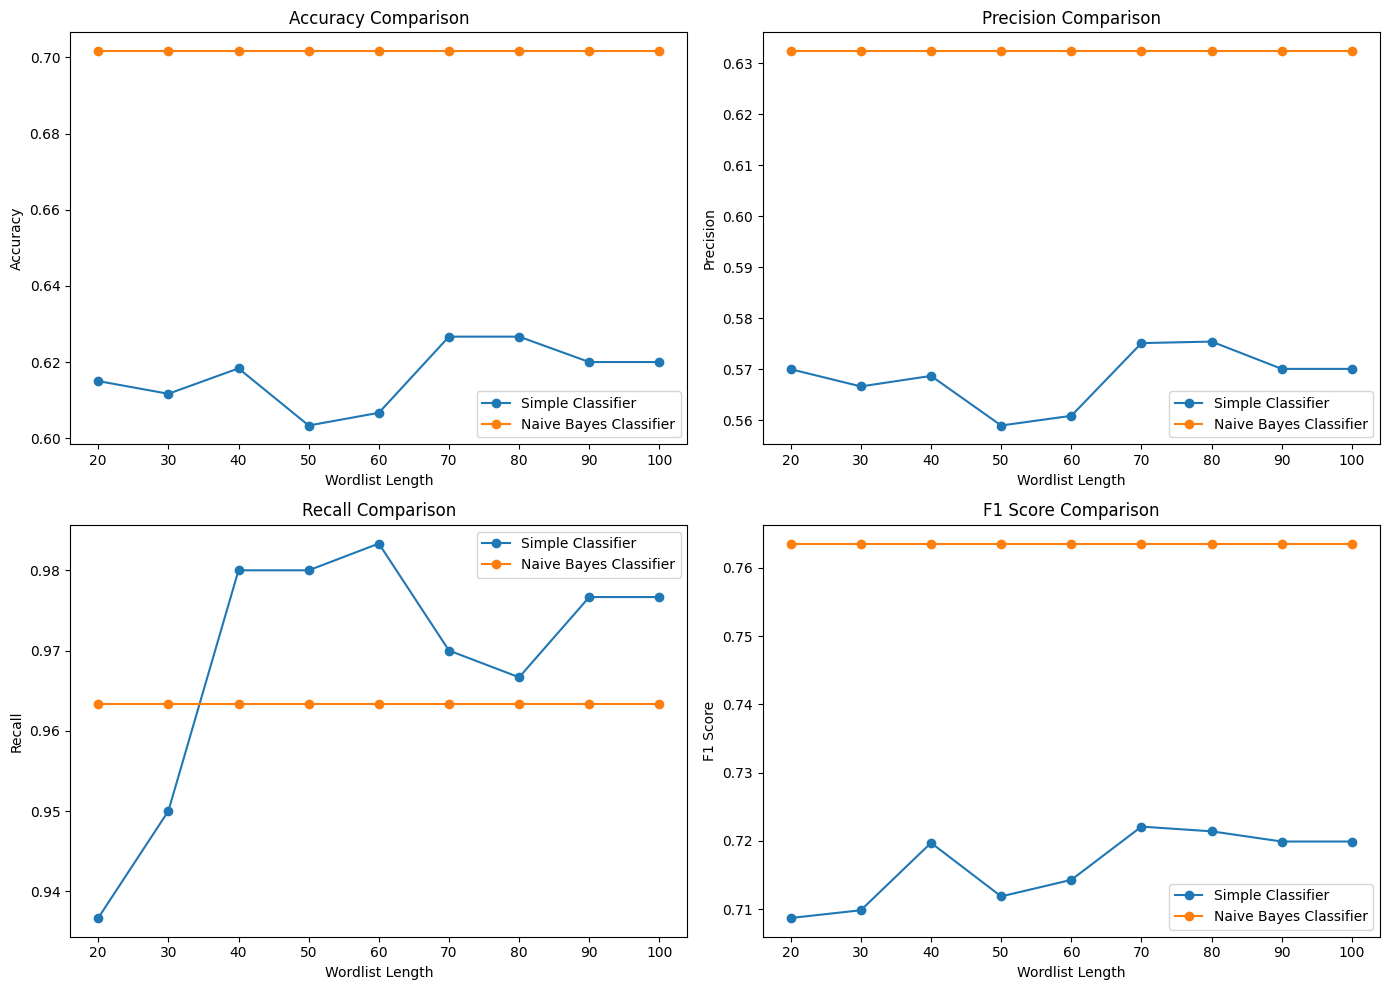

In [20]:
import matplotlib.pyplot as plt

# List to store results for each wordlist length
experiment_results = []

# Range of wordlist lengths to test
wordlist_lengths = [i for i in range(20, 101, 10)]

for length in wordlist_lengths:
    # Generate top-k positive and negative words for the given length
    top_k_pos_words = [word for word, _ in most_freq_words(pos_freq_dist, neg_freq_dist, length)]
    top_k_neg_words = [word for word, _ in most_freq_words(neg_freq_dist, pos_freq_dist, length)]

    # 1. Test SimpleClassifier
    simple_classifier = SimpleClassifier(top_k_pos_words, top_k_neg_words)
    simple_classifier.train( training_norm, length)

    # Classify test data with SimpleClassifier
    simple_results = []
    for reviews, label in testing_norm:

        classified = simple_classifier.classify(FreqDist(reviews))

        simple_results.append((classified, label))

    # Calculate performance metrics for SimpleClassifier
    true_labels = [label for _, label in simple_results]
    simple_class_labels = [pred for pred, _ in simple_results]

    simple_accuracy = accuracy_score(true_labels, simple_class_labels)
    simple_precision = precision_score(true_labels, simple_class_labels, pos_label='pos')
    simple_recall = recall_score(true_labels, simple_class_labels, pos_label='pos')
    simple_f1score = f1_score(true_labels, simple_class_labels, pos_label='pos')

    # 2. Test NaiveBayesClassifier
    # Prepare features for NaiveBayesClassifier
    train_features = [(extract_features(words), label) for words, label in training_norm]
    test_features = [(extract_features(words), label) for words, label in testing_norm]

    # Train NaiveBayesClassifier
    nb_classifier = NaiveBayesClassifier.train(train_features)

    # Classify test data with NaiveBayesClassifier
    nb_results = [(nb_classifier.classify(features), label) for features, label in test_features]

    # Calculate performance metrics for NaiveBayesClassifier
    nb_true_labels = [label for _, label in nb_results]
    nb_class_labels = [pred for pred, _ in nb_results]

    nb_accuracy = accuracy_score(nb_true_labels, nb_class_labels)
    nb_precision = precision_score(nb_true_labels, nb_class_labels, pos_label='pos')
    nb_recall = recall_score(nb_true_labels, nb_class_labels, pos_label='pos')
    nb_f1score = f1_score(nb_true_labels, nb_class_labels, pos_label='pos')

    # Append results for this wordlist length
    experiment_results.append({
        'Wordlist Length': length,
        'Simple Accuracy': simple_accuracy,
        'Simple Precision': simple_precision,
        'Simple Recall': simple_recall,
        'Simple F1 Score': simple_f1score,
        'Naive Bayes Accuracy': nb_accuracy,
        'Naive Bayes Precision': nb_precision,
        'Naive Bayes Recall': nb_recall,
        'Naive Bayes F1 Score': nb_f1score
    })

# Convert results to a DataFrame for easy plotting
experiment_df = pd.DataFrame(experiment_results)

# Plotting the results for comparison
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(experiment_df['Wordlist Length'], experiment_df['Simple Accuracy'], marker='o', label='Simple Classifier')
plt.plot(experiment_df['Wordlist Length'], experiment_df['Naive Bayes Accuracy'], marker='o', label='Naive Bayes Classifier')
plt.xlabel('Wordlist Length')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Precision plot
plt.subplot(2, 2, 2)
plt.plot(experiment_df['Wordlist Length'], experiment_df['Simple Precision'], marker='o', label='Simple Classifier')
plt.plot(experiment_df['Wordlist Length'], experiment_df['Naive Bayes Precision'], marker='o', label='Naive Bayes Classifier')
plt.xlabel('Wordlist Length')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()

# Recall plot
plt.subplot(2, 2, 3)
plt.plot(experiment_df['Wordlist Length'], experiment_df['Simple Recall'], marker='o', label='Simple Classifier')
plt.plot(experiment_df['Wordlist Length'], experiment_df['Naive Bayes Recall'], marker='o', label='Naive Bayes Classifier')
plt.xlabel('Wordlist Length')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 4)
plt.plot(experiment_df['Wordlist Length'], experiment_df['Simple F1 Score'], marker='o', label='Simple Classifier')
plt.plot(experiment_df['Wordlist Length'], experiment_df['Naive Bayes F1 Score'], marker='o', label='Naive Bayes Classifier')
plt.xlabel('Wordlist Length')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()

plt.tight_layout()
plt.show()


### &rarr; B) To answer this question I would like to explain my code at first, then I am going to do my recommendation.
### Code Explanation
In the code, the experiment is set up to test both classifiers (Simple Classifier and Naive Bayes) across various wordlist lengths, ranging from 20 to 100 in increments of 10. This helps us understand how each classifier’s performance is affected by the length of the wordlist.

1. **Wordlist Generation**:
   - For each length in the range, the code first generates the top `k` positive and negative words, where `k` is the current wordlist length. This list is used by the Simple Classifier to make predictions.

2. **Simple Classifier Testing**:
   - A `SimpleClassifier` instance is created with the current top-k positive and negative words.
   - It’s trained on the training data, and then it classifies each review in the test data.

3. **Naive Bayes Classifier Testing**:
   - The Naive Bayes Classifier is trained using `extract_features` to convert each review into a feature dictionary, where each word in the review is marked as `True` if it appears in the text.
   - This dictionary format is what the Naive Bayes Classifier uses to learn word patterns during training.

4. **Result Collection**:
   - For each wordlist length, the results (accuracy, precision, recall, and F1 score) for both classifiers are stored.
   - This data is then used to generate a comparison plot showing how each metric varies with the wordlist length for each classifier.
   - Actually, I just write the same code I perform during earlier questions, but this time our wordlist length is changed, that is why by covering that pieces of code within a for loop with a minor changes I've got the result.

### Experiment
&rarr; I would definitely recommend using the Naive Bayes Classifier for future work in sentiment analysis. What comes out of this experiment is that Naive Bayes constantly outperforms the Simple Classifier in all dimensions, such as accuracy, precision, recall, and F1 score, regardless of the wordlist length. Therefore, Naive Bayes is more effective and stable in this task. That being the case, what induces Naive Bayes to perform better, which is perhaps an important reason, is its probabilistic methodology. While the Simple Classifier looks only for the presence of specific keywords from a predefined list, Naive Bayes takes into consideration the probabilistic occurrence of each word in either positive or negative reviews, having been trained on training data. It tends to possess a more sophisticated feeling of sentiment due to the fact that it can reveal patterns and relations between words. Therefore, even with a variable wordlist length, Naive Bayes is able to adapt to various reviews in content and capture the sentiment.
 - As seen in the plots, the Naive Bayes Classifier’s performance is steady and consistently high, while the Simple Classifier’s performance fluctuates as the wordlist length changes. This consistency makes Naive Bayes a more dependable choice. The Simple Classifier’s keyword-based approach is limited because it relies heavily on the specific words chosen for the wordlist, making it more sensitive to changes in wordlist length.

In [21]:
experiment_df

,Wordlist Length,Simple Accuracy,Simple Precision,Simple Recall,Simple F1 Score,Naive Bayes Accuracy,Naive Bayes Precision,Naive Bayes Recall,Naive Bayes F1 Score
0,20,0.615000,0.569980,0.936667,0.708701,0.701667,0.632385,0.963333,0.76354
1,30,0.611667,0.566600,0.950000,0.709838,0.701667,0.632385,0.963333,0.76354
2,40,0.618333,0.568665,0.980000,0.719706,0.701667,0.632385,0.963333,0.76354
3,50,0.603333,0.558935,0.980000,0.711864,0.701667,0.632385,0.963333,0.76354
4,60,0.606667,0.560837,0.983333,0.714286,0.701667,0.632385,0.963333,0.76354
5,70,0.626667,0.575099,0.970000,0.722084,0.701667,0.632385,0.963333,0.76354
6,80,0.626667,0.575397,0.966667,0.721393,0.701667,0.632385,0.963333,0.76354
7,90,0.620000,0.570039,0.976667,0.719902,0.701667,0.632385,0.963333,0.76354
8,100,0.620000,0.570039,0.976667,0.719902,0.701667,0.632385,0.963333,0.76354


In [24]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/Applied_NLP/A1/ANLPassignment2024.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 1554
